#**Decision Trees Model from Scratch**
This is an implementation of the Decision Tree model which is a machine learning algorithm based on supervised learning to classify whether a mushroom is edible or poisonous.

## OUTLINE
- [ 1 - Packages ](#1)
- [ 2 - Datasets ](#2)
- [ 3 - Prepare Tools and Material ](#3)
- [ 4 - Packages ](#4)
  - [ 4.1 - Calculate entropy ](#4.1)
  - [ 4.2 - Split datasets at node ](#4.2)
  - [ 4.3 - Calculate information gain ](#4.3)
  - [ 4.4 - Get best split ](#4.4)
- [ 5 - Building the tree ](#5)

<a name="1"></a>
## 1 - Problem Statement

Suppose you are a company that grows and sells wild mushrooms. 
- Since not all mushrooms are edible, you'd like to be able to tell whether a given mushroom is edible or poisonous based on it's physical attributes
- You have some existing data that you can use for this task.

**Note**: The dataset used is for illustrative purposes only. It is not meant to be a guide on identifying edible mushrooms.

<a name="2"></a>
## 2 - Datasets
Source of datasets: [Advanced Learning Algorithms by DeepLearning.AI, Coursera](https://www.coursera.org/learn/advanced-learning-algorithms) 

The dataset collected as follows:

10 examples of mushrooms. For each example, we have
  - Three features
      - Cap Color (`Brown` or `Red`)
      - Stalk Shape (Tapering (as in `\/`) or Enlarging (as in `/\`))
      - Solitary (`Yes` or `No`)

- Label
  - Edible (`1` indicating yes or `0` indicating poisonous)

Illustrated below :

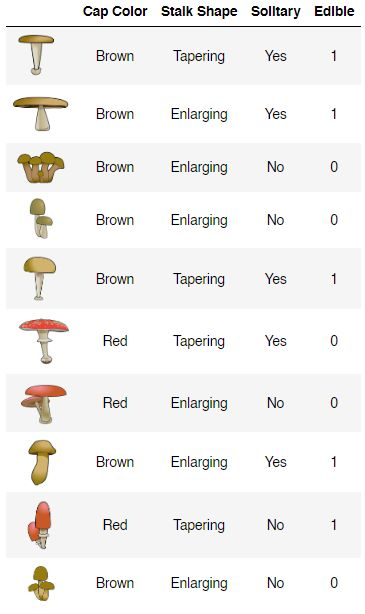

In [72]:
#@title
from IPython.display import Image
Image(filename='/content/edible_mushrooms.jpg')

<a name="3"></a>
## 3 - Prepare Tools and Material

In [54]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/edible_mushrooms.csv')
df

,Cap Color,Stalk Shape,Solitary,Edible or Not
0,Brown,Tapering,Yes,1
1,Brown,Enlarging,Yes,1
2,Brown,Enlarging,No,0
3,Brown,Enlarging,No,0
4,Brown,Tapering,Yes,1
5,Red,Tapering,Yes,0
6,Red,Enlarging,No,0
7,Brown,Enlarging,Yes,1
8,Red,Tapering,No,1
9,Brown,Enlarging,No,0


In [55]:
x_train = df.iloc[:,0:-1]
x_train.head()

,Cap Color,Stalk Shape,Solitary
0,Brown,Tapering,Yes
1,Brown,Enlarging,Yes
2,Brown,Enlarging,No
3,Brown,Enlarging,No
4,Brown,Tapering,Yes


In [56]:
# @title For ease of implementation, let's one-hot encode the features in `x_train`(turned them into 0 or 1 valued features)
x_onehot = pd.get_dummies(x_train)
x_onehot

,Cap Color_Brown,Cap Color_Red,Stalk Shape_Enlarging,Stalk Shape_Tapering,Solitary_No,Solitary_Yes
0,1,0,0,1,0,1
1,1,0,1,0,0,1
2,1,0,1,0,1,0
3,1,0,1,0,1,0
4,1,0,0,1,0,1
5,0,1,0,1,0,1
6,0,1,1,0,1,0
7,1,0,1,0,0,1
8,0,1,0,1,1,0
9,1,0,1,0,1,0


Because there are only 2 options for each feature, we'll only use one hot encoded for each feature

Therefore, 

`x_train` will only contain three features for each example
- Brown Color (A value of `1` indicates "Brown" cap color and `0` indicates "Red" cap color)
- Tapering Shape (A value of `1` indicates "Tapering Stalk Shape" and `0` indicates "Enlarging" stalk shape)
- Solitary  (A value of `1` indicates "Yes" and `0` indicates "No")

In [57]:
  x_train = x_onehot.iloc[:,[0,3,5]]
x_train

,Cap Color_Brown,Stalk Shape_Tapering,Solitary_Yes
0,1,1,1
1,1,0,1
2,1,0,0
3,1,0,0
4,1,1,1
5,0,1,1
6,0,0,0
7,1,0,1
8,0,1,0
9,1,0,0


In [58]:
y_train = df.iloc[:,-1:]
y_train

,Edible or Not
0,1
1,1
2,0
3,0
4,1
5,0
6,0
7,1
8,1
9,0


>- `y_train` is whether the mushroom is edible 
    - `y_train = 1` indicates edible
    - `y_train = 0` indicates poisonous

Now we'll turn `x_train` and `y_train` into numpy array

In [59]:
x_train = np.array(x_train)
print("First few elements of X_train:\n", x_train[:5])
print("Type of X_train:",type(x_train))

First few elements of X_train:
 [[1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 1 1]]
Type of X_train: <class 'numpy.ndarray'>


In [60]:
y_train = np.array(y_train).flatten()
print("First few elements of y_train:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First few elements of y_train:
 [1 1 0 0 1]
Type of y_train: <class 'numpy.ndarray'>


In [61]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (10, 3)
y_train shape: (10,)


<a name="4"></a>
## 4 - How to Build Decision Tree

- The steps for building a decision tree are as follows:
    - Start with all examples at the root node
    - Calculate information gain for splitting on all possible features, and pick the one with the highest information gain
    - Split the datasets according to the selected feature, and create left and right branches of the tree
    - Keep repeating splitting process until stopping criteria is met (for this project, the stopping criteria we've chosen is setting a maximum depth of 2)

<a name="4.1"></a>
### 4.1 - Calculate entropy

Entropy is a measurement of impurity at a node. It is calculated as follows:
* Compute $p_1$, which is the fraction of examples that are edible (i.e. have value = `1` in `y`)
* The entropy is then calculated as $$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1) \tag{1}$$

\
A function called `compute_entropy` will implement the equation above. The function takes in a numpy array (`y`) that indicates whether the examples in that node are edible (`1`) or poisonous(`0`) 


* Note:
    * $0\text{log}_2(0) = 0$. That is, if `p1 = 0` or `p1 = 1`, the entropy will be set to `0`
    * Function will check that the data at a node is not empty (i.e. `len(y) != 0`). and return `0` if it is

In [62]:
def compute_entropy(y):
  m = len(y)
  p1 = 0

  if m != 0:
    for i in range (m):
      if y[i] == 1:
        p1 += 1
    
    p1 = p1/m
    
    if p1 == 0 or p1 == 1:
      H_p1 = 0  
    else:
      
      H_p1 = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
  else:
    H_p1 = 0
  
  entropy = H_p1
  return entropy
    

In [63]:
print("Entropy at root node: ", compute_entropy(y_train)) 
print("Since we have 5 edible and 5 non-edible mushrooms, the entropy should be '1'")

Entropy at root node:  1.0
Since we have 5 edible and 5 non-edible mushrooms, the entropy should be '1'


<a name="4.2"></a>
### 4.2 - Split datasets at node

Next we will make a function called `split_node` that takes in the data at a node and a feature to split on and splits it into left and right branches. 

- The function takes in the training data, the list of indices of data points at that node, along with the feature to split on. 
- It splits the data and returns the subset of indices at the left and the right branch.
- For example, say we're starting at the root node (so `node_indices = [0,1,2,3,4,5,6,7,8,9]`), and we chose to split on feature `0`, which is whether or not the example has a brown cap. 
    - The output of the function is then, `left_indices = [0,1,2,3,4,7,9]` (data points with brown cap) and `right_indices = [5,6,8]` (data points without a brown cap)

In [64]:
def split_node(x, node_indices, features):

  left_indices = []
  right_indices = []

  for i in node_indices:
    if x[i,features] == 1:
      left_indices.append(i)
    else:
      right_indices.append(i)

  return left_indices, right_indices 

In [65]:
root_indices = [0,1,2,3,4,5,6,7,8,9]
left_node,right_node = split_node(x_train,root_indices, 0)
left_node,right_node

([0, 1, 2, 3, 4, 7, 9], [5, 6, 8])

<a name="4.3"></a>
### 4.3 - Calculate information gain

Next, we'll write a function called `count_information_gain` that takes in the training data, the indices at a node and a feature to split on and returns the information gain from the split.

It is calculated as follows:

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right})) \tag{2}$$

where 
- $H(p_1^\text{node})$ is entropy at the node 
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch, respectively

In [66]:
def count_information_gain(x,y,node_indices,features):

  left_indices, right_indices = split_node(x,node_indices,features)

  x_node, y_node = x[node_indices], y[node_indices]
  x_left, y_left = x[left_indices], y[left_indices]
  x_right, y_right = x[right_indices], y[right_indices]

  gain = 0

  w_left = len(x_left) / len(x_node)
  w_right = len(x_right) / len(x_node)
  
  gain = compute_entropy(y_node) - (w_left * compute_entropy(y_left) + w_right * compute_entropy(y_right))

  return gain

In [67]:
info_gain0 = count_information_gain(x_train, y_train, root_indices, 0)
print("Information Gain from splitting the root on brown cap: ", info_gain0)
count_information_gain
info_gain1 = count_information_gain(x_train, y_train, root_indices, 1)
print("Information Gain from splitting the root on tapering stalk shape: ", info_gain1)

info_gain2 = count_information_gain(x_train, y_train, root_indices, 2)
print("Information Gain from splitting the root on solitary: ", info_gain2)

Information Gain from splitting the root on brown cap:  0.034851554559677034
Information Gain from splitting the root on tapering stalk shape:  0.12451124978365313
Information Gain from splitting the root on solitary:  0.2780719051126377


<a name="4.4"></a>
### 4.4 - Get best split
Now let's write a function to get the best feature to split on by computing the information gain from each feature as we did above and returning the feature that gives the maximum information gain

The function will be called `best_split()`


- Note
  - The function takes in the training data, along with the indices of datapoint at that node
  - The output of the function is the feature that gives the maximum information gain 
  - We can use the `count_information_gain()` function to iterate through the features and calculate the information for each feature

In [68]:
def best_split(x,y,root_indices):
  num_features = len(x[0])

  highest_info_gain = -1
  features_index = None

  for i in range (num_features):
    gain = count_information_gain(x, y, root_indices, i)

    if gain > highest_info_gain:
      highest_info_gain = gain
      features_index = i

  return features_index

In [69]:
best_feature = best_split(x_train, y_train, root_indices)
print("Best feature to split on: %d" % best_feature)

Best feature to split on: 2


<a name="5"></a>
## 5 - Building the tree

In this section, we use the functions implemented above to generate a decision tree by successively picking the best feature to split on until we reach the stopping criteria (maximum depth is 2).

In [70]:
def tree_recursive(x,y,root_indices,branch, max_depth,current_depth):

  if current_depth == max_depth:
    print(f'-- {branch} node, indices {root_indices}')
    return
  
  best_feature = best_split(x,y,root_indices)

  print()
  print(f'{branch} Node, current depth = {current_depth}. Split on feature = {best_feature}')

  left_indices,right_indices = split_node(x, root_indices, best_feature)

  tree_recursive(x,y,left_indices,'Left', max_depth,current_depth+1)
  tree_recursive(x,y,right_indices,'Right', max_depth,current_depth+1)



In [71]:
tree_recursive(x_train,y_train,root_indices,'Root',2,0)


Root Node, current depth = 0. Split on feature = 2

Left Node, current depth = 1. Split on feature = 0
-- Left node, indices [0, 1, 4, 7]
-- Right node, indices [5]

Right Node, current depth = 1. Split on feature = 1
-- Left node, indices [8]
-- Right node, indices [2, 3, 6, 9]
